In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import time
from datetime import datetime
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import system_comparison_plots
%matplotlib inline


# Load the results

In [51]:
df = system_comparison_plots.load_e2e_experiments()
summary_fname = "results_summary.pkl"
df.to_pickle(summary_fname)
df = pd.read_pickle(summary_fname)

In [20]:
df

,CV,cost,lambda,name,slo,slo_miss_rate,slo_plus_25_per_miss_rate,utilization
0,4.0,13.1055,413,InferLine,0.50,0.000000,0.000000,0.8
1,4.0,10.5110,264,InferLine,0.50,0.011633,0.006431,0.8
2,4.0,15.7000,453,InferLine,0.50,0.000000,0.000000,0.8
3,4.0,5.3220,81,InferLine,0.50,0.000000,0.000000,0.8
4,4.0,18.2945,627,InferLine,0.50,0.000000,0.000000,0.8
5,4.0,7.9165,177,InferLine,0.50,0.000000,0.000000,0.8
6,1.0,18.2945,699,InferLine,0.50,0.000063,0.000000,0.8
7,1.0,7.9165,227,InferLine,0.50,0.000000,0.000000,0.8
8,1.0,15.7000,513,InferLine,0.50,0.000000,0.000000,0.8
9,1.0,10.5110,330,InferLine,0.50,0.009252,0.000752,0.8


# Plot the results

In [33]:
def bytes_per_machine(cost, bts):
    cost = np.array(cost)
    bts = np.array(bts)
    res = []
    for i in range(len(cost)):
        if cost[i] < 10.6:
            res.append(bts[i])
        else:
            res.append(bts[i]/2.0)
    return res

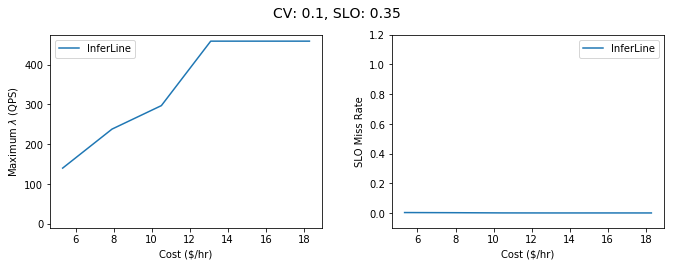

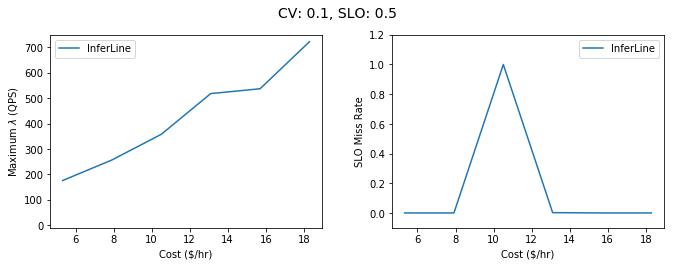

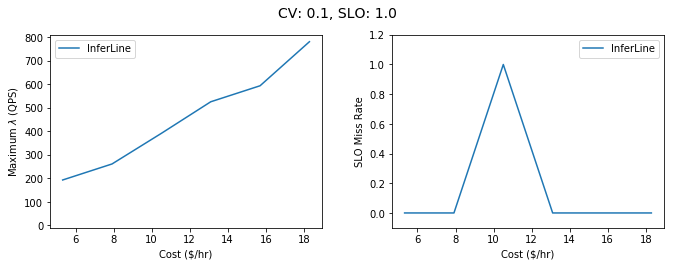

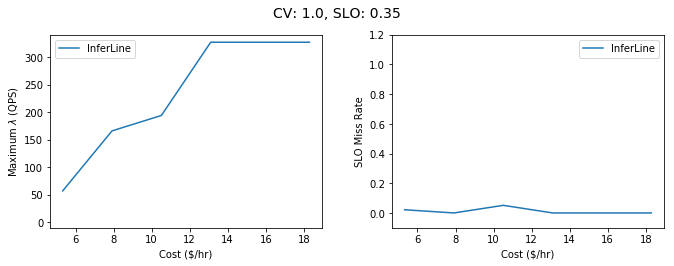

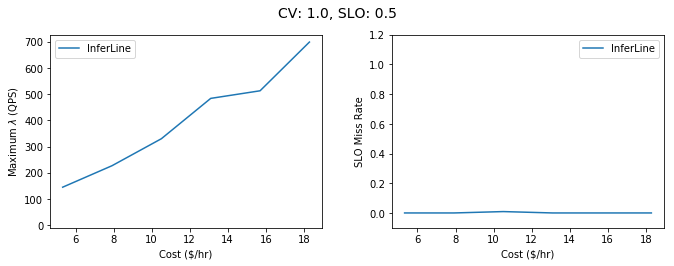

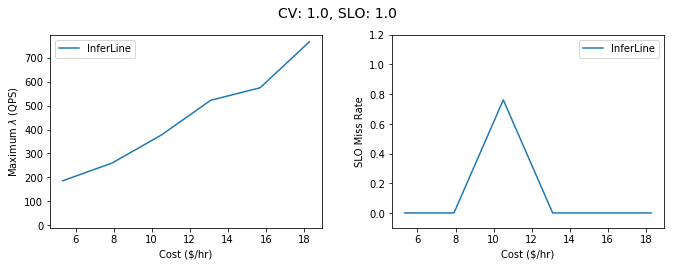

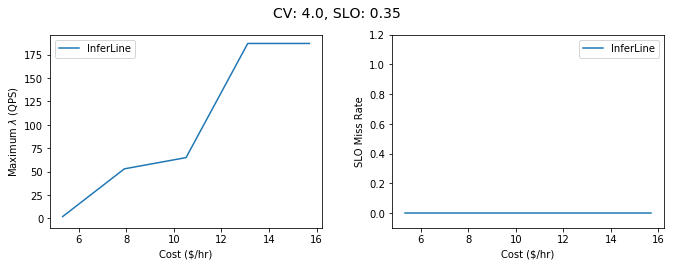

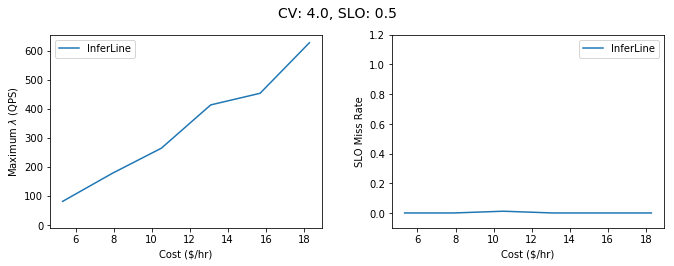

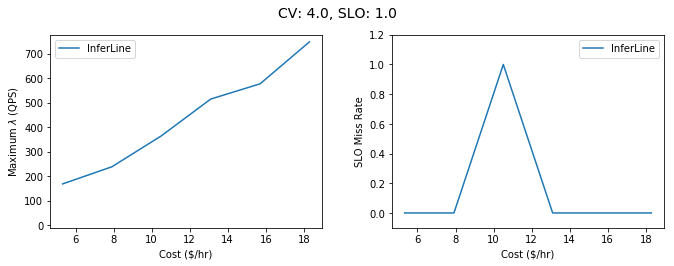

In [52]:
bytes_per_query = 299*299*4*3 + 2*2048*4 + 4 + 224*224*3*4 + 2*2048*4 + 4
MB_per_query = bytes_per_query / 1000.0 / 1000.0






for cv, cv_group in df.groupby(df.CV):
    for slo, slo_group in cv_group.groupby(cv_group.slo):
#         fig, (ax_lam, ax_slo, ax_slo_25) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
        fig, (ax_lam, ax_slo) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

#         ax_lam_bytes_per_machine = ax_lam.twinx()
        for name, name_group in slo_group.groupby(slo_group.name):
            name_group = name_group.sort_values("cost")
            ax_lam.plot(name_group.cost, name_group["lambda"], label=name)
            bpm = bytes_per_machine(name_group["cost"], name_group["lambda"]*MB_per_query)
#             ax_lam_bytes_per_machine.plot(name_group.cost, bpm, label=name, color="red")
            ax_slo.plot(name_group.cost, name_group.slo_miss_rate, label=name)
#             ax_slo_25.plot(name_group.cost, name_group.slo_plus_25_per_miss_rate, label=name)
        ax_lam.set_ylabel("Maximum $\lambda$ (QPS)")
        ax_lam.set_xlabel("Cost ($/hr)")
        ax_lam.set_ylim(bottom=-10)
        ax_slo.set_xlabel("Cost ($/hr)")
        ax_slo.set_ylabel("SLO Miss Rate")
        ax_slo.set_ylim((-.1,1.2))
#         ax_slo_25.set_xlabel("Cost ($/hr)")
#         ax_slo_25.set_ylabel("(SLO + 25%) Miss Rate")
#         ax_slo_25.set_ylim((-.1,1.2))
#         ax_lam_bytes_per_machine.set_ylabel("Per-Node Ingress Traffic (MBps)")
#         ax_lam_bytes.set_ylabel("MBps")
#         mn, mx = ax_lam.get_ylim()
#         ax_lam_bytes.set_ylim(mn*MB_per_query, mx*MB_per_query)

        ax_slo.legend(loc=0)
#         ax_slo_25.legend(loc=0)
        

        ax_lam.legend(loc=0)
        fig.suptitle("CV: {cv}, SLO: {slo}".format(cv=cv, slo=slo), fontsize=14)
        plt.tight_layout(pad=3)

            
    

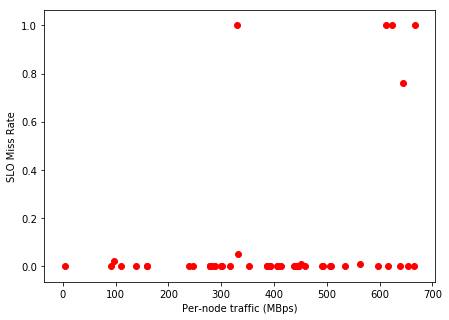

In [39]:
fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
for cv, cv_group in df.groupby(df.CV):
    for slo, slo_group in cv_group.groupby(cv_group.slo):
        for name, name_group in slo_group.groupby(slo_group.name):
            ax2.scatter(bytes_per_machine(name_group["cost"], name_group["lambda"]*MB_per_query), name_group["slo_miss_rate"], color="red")
ax2.set_ylabel("SLO Miss Rate")
ax2.set_xlabel("Per-node traffic (MBps)")
fig.suptitle("Effect of contention on SLO miss rate")
